In [96]:
import pandas as pd
import numpy as np
from numpy import quantile, where
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [97]:
df=pd.read_csv('ec2_cpu_utilization_5f5533.csv', parse_dates=['timestamp'])

In [98]:
df.describe()

,value
count,4032.000000
mean,43.110372
std,4.303565
min,34.766000
25%,39.296000
50%,42.918000
75%,46.006000
max,68.092000


In [99]:
df.dtypes

timestamp    datetime64[ns]
value               float64
dtype: object

In [100]:
df.head()

,timestamp,value
0,2014-02-14 14:27:00,51.846
1,2014-02-14 14:32:00,44.508
2,2014-02-14 14:37:00,41.244
3,2014-02-14 14:42:00,48.568
4,2014-02-14 14:47:00,46.714


I chose to visualize the data first before training the anomoly detection models. The violin plot showed me that there were definitely anomolies in the dataset, as determined by the interquartile range of the plot. 

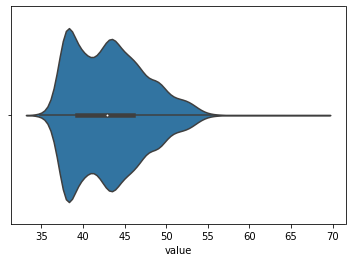

In [101]:
ax =  sns.violinplot(x=df['value'])

I also chose to do a box plot for a different perspective

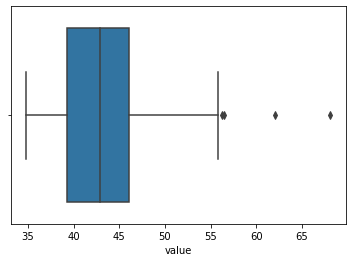

In [102]:
ax=sns.boxplot(x=df['value'])

In [103]:
X=df['value']
X=X.values.reshape(-1,1)

The first model I trained was Isolation Forest. It performed quite badly, but it could be improved if the hyperparameters were tuned. I chose not to tune these because that is not the primary purpose of this project, nor have we covered that in class yet. 

In [104]:
model_if=IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', max_features=1)

In [105]:
model_if.fit(X)

IsolationForest(max_features=1)

In [106]:
df['scores']=model_if.decision_function(df[['value']])
df['anomaly']=model_if.predict(df[['value']])

In [107]:
df.head()

,timestamp,value,scores,anomaly
0,2014-02-14 14:27:00,51.846,-0.101501,-1
1,2014-02-14 14:32:00,44.508,0.032153,1
2,2014-02-14 14:37:00,41.244,0.012532,1
3,2014-02-14 14:42:00,48.568,-0.021054,-1
4,2014-02-14 14:47:00,46.714,0.013350,1


In [108]:
if_anomaly=df.loc[df['anomaly']==-1]
anomaly_index=list(if_anomaly.index)
print(if_anomaly)

               timestamp   value    scores  anomaly
0    2014-02-14 14:27:00  51.846 -0.101501       -1
3    2014-02-14 14:42:00  48.568 -0.021054       -1
6    2014-02-14 14:57:00  49.108 -0.029604       -1
8    2014-02-14 15:07:00  53.404 -0.157192       -1
11   2014-02-14 15:22:00  49.720 -0.054091       -1
...                  ...     ...       ...      ...
4006 2014-02-28 12:17:00  36.568 -0.136897       -1
4018 2014-02-28 13:17:00  37.056 -0.073837       -1
4020 2014-02-28 13:27:00  36.714 -0.106595       -1
4022 2014-02-28 13:37:00  37.206 -0.059810       -1
4025 2014-02-28 13:52:00  37.090 -0.069387       -1

[1012 rows x 4 columns]


I chose the value 57 here based on the box plot above. This corresponds roughly with where it determined the outlier threshold to be.

In [109]:
if_outliers=len(df[df['value'] > 57])
print('Accuracy percentage:', 100*list(df['anomaly']).count(-1)/(if_outliers))

Accuracy percentage: 50600.0


Next, I trained a Local Outlier Factor model. I set n_neighbors equal to 20 because it was the default. However, after testing it with other values of 10 and 30, n_neighbors=20 seems to fit the data best. 

In [110]:
model_lof=LocalOutlierFactor(n_neighbors=20)
y_pred=model_lof.fit_predict(X)

In [111]:
neg_scores=model_lof.negative_outlier_factor_

In [112]:
threshold=quantile(neg_scores, .03)
print(threshold)

-1.190137490689049


In [113]:
index=where(neg_scores<=threshold)
a=X[index]

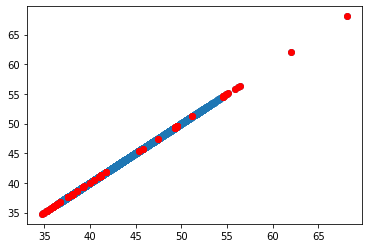

In [114]:
plt.scatter(X[:, 0], X[:, 0])
plt.scatter(a[:, 0], a[:, 0], color='r')

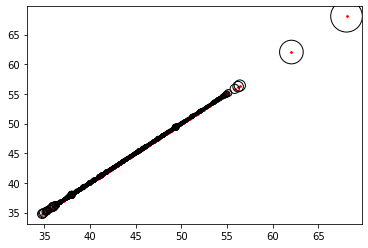

In [115]:
plt.scatter(X[:, 0], X[:, 0], color='r', s=3., label='data points')
radius= (neg_scores.max() - neg_scores) / (neg_scores.max() - neg_scores.min())
plt.scatter(X[:,0], X[:, 0], s=1000 * radius, edgecolor='k', facecolors='none', label='outlier scores')

n_neighbors=10 definitely does not fit the data. It identifies the anomolies incorrectly.

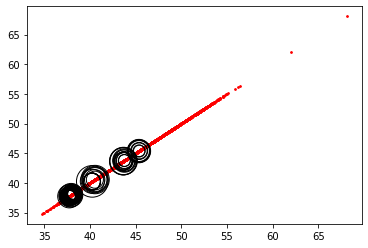

In [116]:
model_lof1=LocalOutlierFactor(n_neighbors=10)
y_pred1=model_lof1.fit_predict(X)
neg_scores1=model_lof1.negative_outlier_factor_
plt.scatter(X[:, 0], X[:, 0], color='r', s=3., label='data points')
radius1= (neg_scores1.max() - neg_scores1) / (neg_scores1.max() - neg_scores1.min())
plt.scatter(X[:,0], X[:, 0], s=1000 * radius1, edgecolor='k', facecolors='none', label='outlier scores')

n_neighbors=30 does not really improve the anomoly detection.

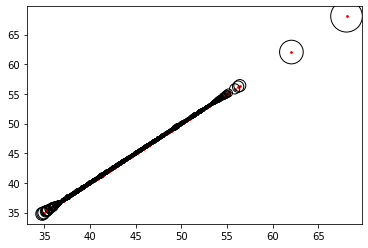

In [117]:
model_lof1=LocalOutlierFactor(n_neighbors=30)
y_pred1=model_lof1.fit_predict(X)
neg_scores1=model_lof1.negative_outlier_factor_
plt.scatter(X[:, 0], X[:, 0], color='r', s=3., label='data points')
radius1= (neg_scores1.max() - neg_scores1) / (neg_scores1.max() - neg_scores1.min())
plt.scatter(X[:,0], X[:, 0], s=1000 * radius1, edgecolor='k', facecolors='none', label='outlier scores')

I also tried changing the threshold to see how that affected the model when n_neighbors=20.

-1.2295815583827872


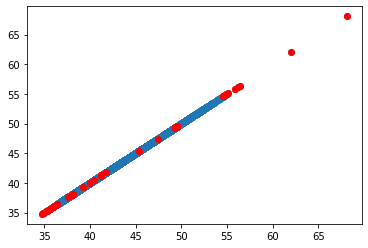

In [118]:
threshold=quantile(neg_scores, .02)
print(threshold)
index=where(neg_scores<=threshold)
a=X[index]
plt.scatter(X[:, 0], X[:, 0])
plt.scatter(a[:, 0], a[:, 0], color='r')

-1.4023997409977982


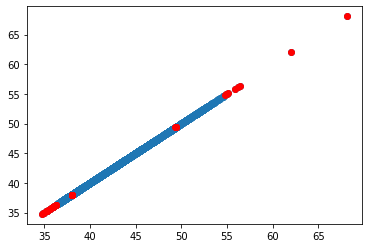

In [119]:
threshold=quantile(neg_scores, .01)
print(threshold)
index=where(neg_scores<=threshold)
a=X[index]
plt.scatter(X[:, 0], X[:, 0])
plt.scatter(a[:, 0], a[:, 0], color='r')

-1.7246598837161455


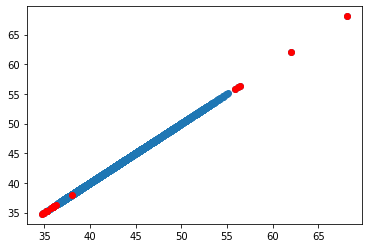

In [120]:
threshold=quantile(neg_scores, .005)
print(threshold)
index=where(neg_scores<=threshold)
a=X[index]
plt.scatter(X[:, 0], X[:, 0])
plt.scatter(a[:, 0], a[:, 0], color='r')

The plot above with a threshold=0.005 and n_neighbors=20 seems to be the best at anomoly detection of the models that I trained. 